In [2]:
import gmplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import DBSCAN

import math
import time
import datetime
import os

filedir = 'Z:/C Brace/GPS Analysis'

## Wear Time w/ GPS Data

In [2]:
def getDatetime(stringDTSeries):
    try:
        return [datetime.datetime.strptime(DT,'%m/%d/%Y %I:%M %p') for DT in stringDTSeries]
    except(ValueError):
        return [datetime.datetime.strptime(DT,'%m/%d/%Y %H:%M') for DT in stringDTSeries]

### Match wear time to GPS data

In [3]:
for device in ['CBrace', 'SCO', 'KAFO']:

    print(device)
    if device == 'KAFO':
        device2 = 'Baseline'
    else:
        device2 = device
    
    for i in range(8,32):

        if not(os.path.isfile(filedir + '\GPSWT\CBR' + str(i).zfill(2) + '_' + device2 + '.csv')):

            try:
                try:
                    data = pd.read_csv('Z:/C Brace/Actigraph/Data/Home/CBR ' + str(i).zfill(2) + '/Merged/WearTime_' + device + '_Device.csv')

                    try:
                        I = data.index
                        I = [i[0] for i in I]
                        
                    except(IndexError):
                        I = [i for i in data.iloc[:,0]]
                        I.pop(0)

                    data = pd.read_csv('Z:/C Brace/Actigraph/Data/Home/CBR ' + str(i).zfill(2) + '/Merged/WearTime_' + device + '_Device.csv',
                                       skiprows=I.index('Date/Time Start')+2)
                except(OSError):
                    data = pd.read_csv('Z:/C Brace/Actigraph/Data/Home/CBR ' + str(i).zfill(2) + '/WearTime_' + device + '_Device.csv')

                    try:
                        I = data.index
                        I = [i[0] for i in I]
                        
                    except(IndexError):
                        I = [i for i in data.iloc[:,0]]
                        I.pop(0)

                    data = pd.read_csv('Z:/C Brace/Actigraph/Data/Home/CBR ' + str(i).zfill(2) + '/WearTime_' + device + '_Device.csv',
                                       skiprows=I.index('Date/Time Start')+2)

                DF=data[['Date/Time Start', 'Date/Time Stop']]

                WT_StartStop = DF.apply(getDatetime)
                WT_StartStop = pd.concat([WT_StartStop, data['Wear or Non-Wear']], axis=1)
                WT_StartStop = WT_StartStop[WT_StartStop['Wear or Non-Wear']=='Wear']

                GPSdata = pd.read_csv(filedir +  '/GPS Data/CBR' + str(i).zfill(2) + '_' + device2  + '.csv')

                GPS_TS = GPSdata['LOCAL DATE'] + ' ' + GPSdata['LOCAL TIME']

                try:
                    GPS_TS = [datetime.datetime.strptime(DT,'%m/%d/%Y %H:%M:%S') for DT in GPS_TS]
                except(ValueError):
                    GPS_TS = [datetime.datetime.strptime(DT,'%Y/%m/%d %H:%M:%S') for DT in GPS_TS]

                WT_StartStop.iloc[0,0]

                GPS_TS = pd.Series(GPS_TS)

                inds = (GPS_TS<WT_StartStop.iloc[0,1]) & (GPS_TS>WT_StartStop.iloc[0,0])

                GPS_WT = ['Non-Wear'] * len(inds)
                GPS_WT = pd.Series(GPS_WT)

                for Start, Stop in zip(WT_StartStop['Date/Time Start'], WT_StartStop['Date/Time Stop']):
                    inds = (GPS_TS<Stop) & (GPS_TS>Start)
                    GPS_WT[inds] = 'Wear'

                GPS = pd.concat([GPSdata, GPS_WT],axis=1).rename(index=int,columns={0:'Wear/Non-Wear'})

                GPS.to_csv(filedir + '\GPSWT\CBR' + str(i).zfill(2) + '_' + device2 + '.csv')
            except(OSError):
                print('CBR' + str(i).zfill(2))

CBrace
CBR09
CBR10
CBR12
CBR14
CBR17
CBR18
CBR20
CBR23
CBR29
SCO
CBR09
CBR10
CBR12
CBR13
CBR14
CBR17
CBR18
CBR20
CBR23
CBR25
CBR29
KAFO
CBR08
CBR09
CBR10
CBR12
CBR13
CBR14
CBR17
CBR18
CBR20
CBR23
CBR29


In [ ]:
D = {'CBrace':float('nan'), 'SCO':float('nan'), 'Baseline':float('nan')}

for device in ['CBrace', 'SCO', 'Baseline']:

    gmap_large = gmplot.GoogleMapPlotter(41.787679, -88.135474,12)
    gmap_small = gmplot.GoogleMapPlotter(41.787679, -88.135474,8)
    
    print(device)
    
    Time = [float('nan')] * 31; Freq = [float('nan')]*31; WTRatio = [float('nan')]*31;
    
    for i in range(8,32):

        print('CBR' + str(i).zfill(2))
        
        try:
            Data = pd.read_csv(filedir + '/GPSWT/CBR' + str(i).zfill(2) + '_' + device + '.csv')

            Lat = Data.LATITUDE
            Lon = Data.LONGITUDE

            Data.loc[Data.iloc[:,12]=="W","LONGITUDE"] = Data.loc[Data.iloc[:,12]=="W","LONGITUDE"]*-1
            dArray = Data[["LATITUDE","LONGITUDE"]].values

            dbscan = DBSCAN(metric='haversine', eps=50/6371000, min_samples=int(360*len(dArray)/200000), algorithm='ball_tree')
            t0 = time.clock()
            clusters = dbscan.fit(np.radians(dArray))
            t1 = time.clock()
            print(t1-t0)
            l=clusters.labels_
            print(len(np.unique(l)))
            
            f = sum(np.diff(l)!=0)/(len(l)-1)*6*60*24
            t = [sum(l==c) for c in np.unique(l[l!=-1])]
            wt = [sum((l==c) & (Data['Wear/Non-Wear']=='Wear'))/sum(l==c) for c in np.unique(l[l!=-1])]
            
            Freq[i-1] = f; Time[i-1] = t; WTRatio[i-1] = wt
            
            homeInd = np.argmax(t)
            print(homeInd)
            offset = np.array([41.787679, -88.135474]) - np.array([np.mean(dArray[l==homeInd][:,0]), np.mean(dArray[l==homeInd][:,1])])
            
#             homeSize = (np.max(dArray[l==homeInd][:,0])-np.min(dArray[l==homeInd][:,0]))*(np.max(dArray[l==homeInd][:,1])-np.min(dArray[l==homeInd][:,1]))
            homeSize = sum(l==homeInd)
    
            # array for lats and longs
            m1_all = []
            m2_all = []
            # array for colors
            col_all = []
            
            for c in np.unique(l[l!=-1]):
                m = np.array([np.mean(dArray[l==c][:,0]), np.mean(dArray[l==c][:,1])]) + offset
                # Size based on physical space covered by cluster
#                 s1 = (np.max(dArray[l==c][:,0])-np.min(dArray[l==c][:,0]))
#                 s2 = (np.max(dArray[l==c][:,1])-np.min(dArray[l==c][:,1]))
#                 print(s1*s2)

                # Size based on time spent in cluster
                s1 = sum(l==c)
                s2 = 1
#                 print(math.sqrt(s1*s2))

                # colorscale based on weartime fraction
                col = sum((l==c) & (Data['Wear/Non-Wear']=='Wear'))/sum(l==c)
                
                m1_all.append(m[0])
                m2_all.append(m[1])
                col_all.append(col)
                
                gmap_large.scatter([m[0], m[0]],[m[1], m[1]],
                                   color='#%02x%02x%02x' % (int(col*255), 255-int(col*125), 0), size=math.sqrt(s1*s2/homeSize)*500, marker=False)
            
                gmap_small.scatter([m[0], m[0]],[m[1], m[1]],
                                   color='#%02x%02x%02x' % (int(col*255), 255-int(col*125), 0), size=math.sqrt(s1*s2/homeSize)*80, marker=False)
            
        except(OSError):
            print('No File')
            
    DF = pd.DataFrame({'Time':Time, 'WTRatio':WTRatio, 'Freq':Freq})
    D[device] = DF
    
    
    gmap_large.draw(device + "_large.html")
    gmap_small.draw(device + "_small.html")
    
Results = pd.Panel(D)

CBrace
CBR08
98.56425182259409
11
0
CBR09
No File
CBR10
No File
CBR11
276.79726975475205
12
0
CBR12
No File
CBR13
28.538206926255953
15
1
CBR14
No File
CBR15
42.9681046596379
31
0
CBR16
60.17686039756518
12
0
CBR17
No File
CBR18
No File
CBR19
441.6078708586283
4
0
CBR20
No File
CBR21
375.57609953481006
14
0
CBR22
4.619019231700804
32
4
CBR23
No File
CBR24
628.497243554506
7
0
CBR25
1109.9200130459503
5
0
CBR26
2243.2930442122743
8
0
CBR27
132.6779872374027
2
0
CBR28
623.8482282885234
3
0
CBR29
No File
CBR30
349.3615908555221
22
0
CBR31
328.23944084800314
10
0
SCO
CBR08
77.39437113213353
28
0
CBR09
No File
CBR10
No File
CBR11
5.51454599830322
12
0
CBR12
No File
CBR13
No File
CBR14
No File
CBR15
115.210740857583
8
0
CBR16
140.31882396980654
13
1
CBR17
No File
CBR18
No File
CBR19
494.1540969501366
2
0
CBR20
No File
CBR21
354.5816825593356
10
0
CBR22
0.7330904889968224
39
1
CBR23
No File
CBR24
111.3599270383711
4
0
CBR25
No File
CBR26
495.6340528857545
11
0
CBR27


In [53]:
c

10

In [15]:
def getNClusters(S):
    X = []
    for e in S:
        try:
            check = any(np.isnan(e))
        except(TypeError):
            check = np.isnan(e)
            
        if check:
            X.append(e)
        else:
            X.append(len(e))
    
    return X

In [16]:
N_Clusters = Results.minor_xs('Time').apply(getNClusters) # number of clusters for each subject/brace

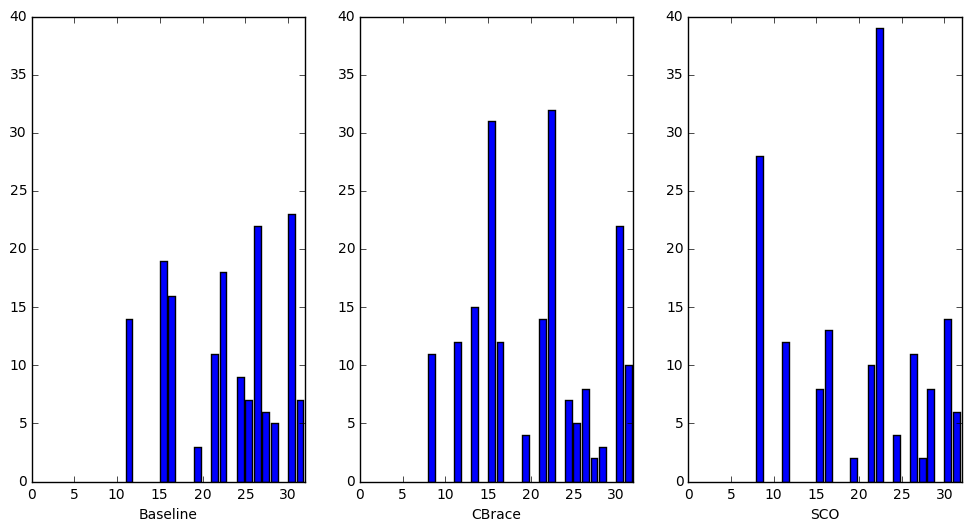

In [19]:
fig = plt.figure(figsize=(12,6))
for i, C in enumerate(N_Clusters.columns):
    ax = fig.add_subplot(1,3,i+1)
    ax.bar(range(1,32),np.asarray(N_Clusters[C]))
    ax.set_xlim(left = 0, right = 32)
    ax.set_ylim(0,40)
    ax.set_xlabel(C)

In [20]:
def getTimeAverage(S):
    X = []
    for e in S:
        try:
            check = any(np.isnan(e))
        except(TypeError):
            check = np.isnan(e)
            
        if check:
            X.append(e)
        else:
            X.append(np.mean(np.sort(e)[0:len(e)-1])/np.max(e)) # Average time spent in other clusters relative to Home

    return X

def getTimeRatio(S):
    X = []
    for e in S:
        try:
            check = any(np.isnan(e))
        except(TypeError):
            check = np.isnan(e)
            
        if check:
            X.append(e)
        else:
            X.append(np.sum(np.sort(e)[0:len(e)-1])/np.max(e)) # Total time spent in other clusters relative to Home

    return X

In [21]:
MeanTime = Results.minor_xs('Time').apply(getTimeAverage) # Average time spent in other clusters relative to Home
RatioTime = Results.minor_xs('Time').apply(getTimeRatio) # Total time spent in other clusters relative to Home

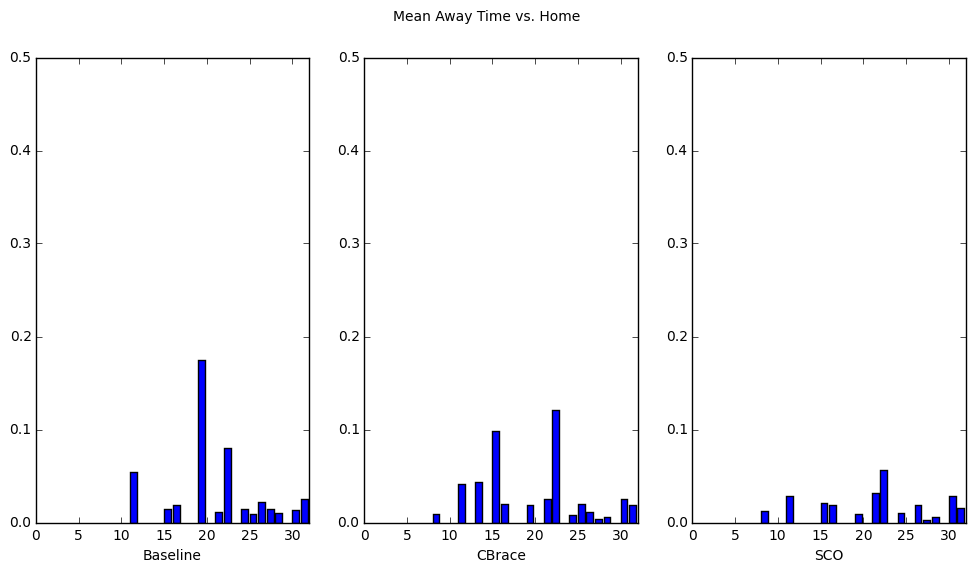

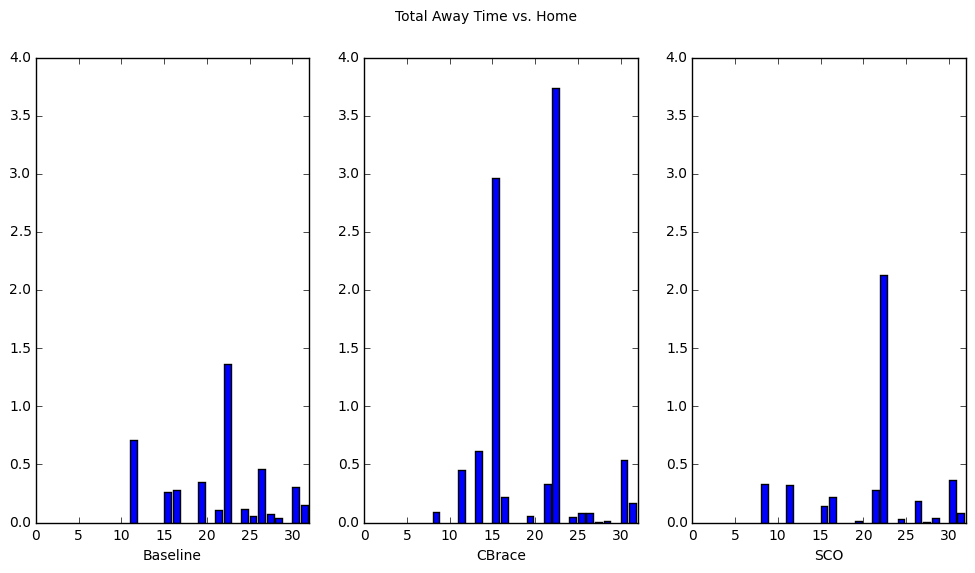

In [22]:
fig = plt.figure(figsize=(12,6))
fig.suptitle('Mean Away Time vs. Home')
for i, C in enumerate(MeanTime.columns):
    ax = fig.add_subplot(1,3,i+1)
    ax.bar(range(1,32),np.asarray(MeanTime[C]))
    ax.set_xlim(left = 0, right = 32)
    ax.set_ylim(0,.5)
    ax.set_xlabel(C)
    
fig = plt.figure(figsize=(12,6))
fig.suptitle('Total Away Time vs. Home')
for i, C in enumerate(RatioTime.columns):
    ax = fig.add_subplot(1,3,i+1)
    ax.bar(range(1,32),np.asarray(RatioTime[C]))
    ax.set_xlim(left = 0, right = 32)
    ax.set_ylim(0,4)
    ax.set_xlabel(C)

In [23]:
def getWTimeAverage(S):
    
    try:
        check = any(np.isnan(S['Time']))
    except(TypeError):
        check = np.isnan(S['Time'])
    
    if check:
        return float('nan')
    else:
        ind = np.argmax(S['Time'])
        d = pd.Series(S['WTRatio'])
        
        return d

def getWTimeHome(S):
    
    try:
        check = any(np.isnan(S['Time']))
    except(TypeError):
        check = np.isnan(S['Time'])
    
    if check:
        return float('nan')
    else:
        return S['WTRatio'][np.argmax(S['Time'])]


In [24]:
DHome = {};
DMean = {};

for C in Results.items:

    DHome[C] = Results[C].apply(getWTimeHome,axis=1)
    DMean[C] = Results[C].apply(getWTimeAverage,axis=1).apply(np.mean)
    
WTHome = pd.DataFrame(DHome) # WT ratio in Home cluster
WTMean = pd.DataFrame(DMean) # Average WT ratio in away clusters

Baseline
CBrace
SCO


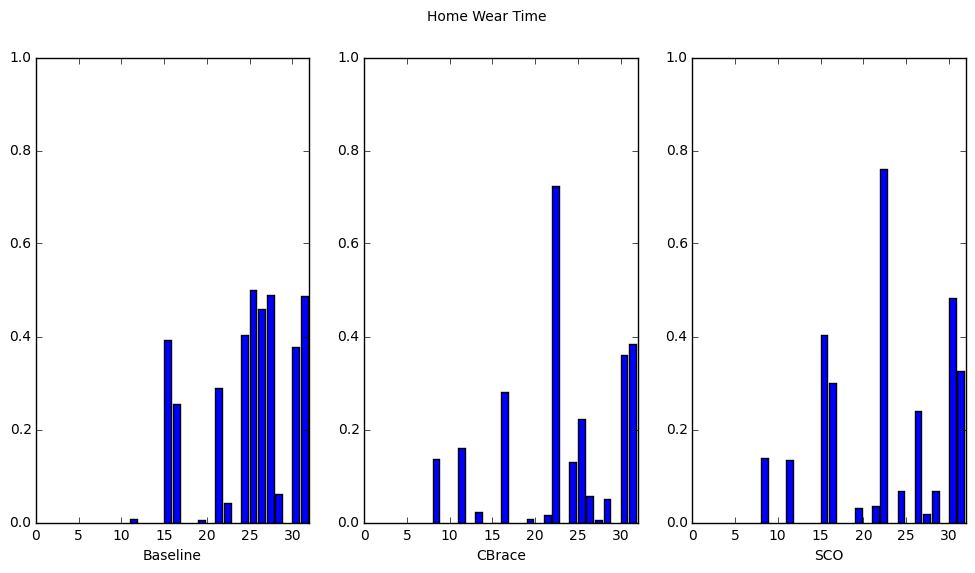

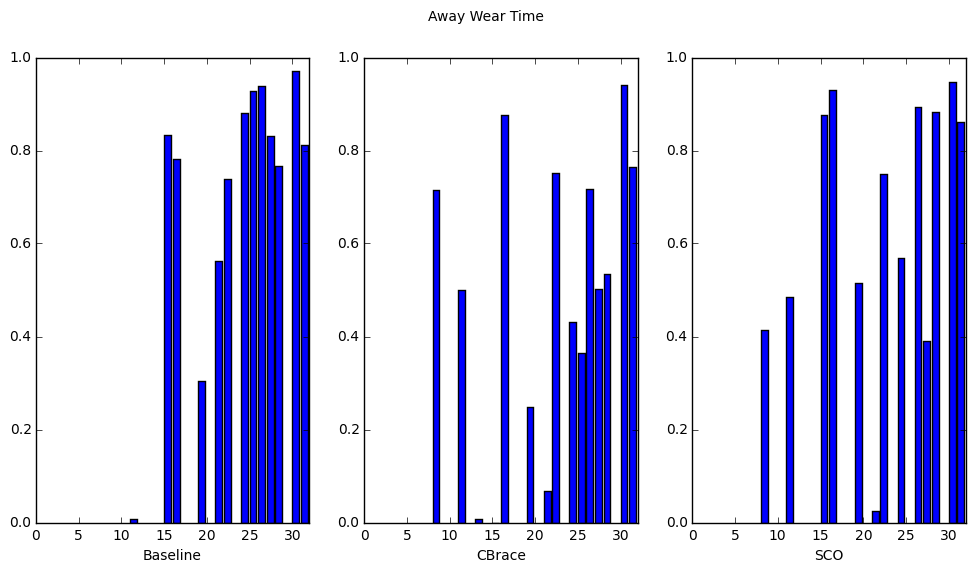

In [38]:
fig = plt.figure(figsize=(12,6))
fig.suptitle('Home Wear Time')
for i, C in enumerate(WTHome.columns):
    ax = fig.add_subplot(1,3,i+1)
    ax.bar(range(1,32),np.asarray(WTHome[C]))
    ax.set_xlim(left = 0, right = 32)
    ax.set_ylim(0,1)
    ax.set_xlabel(C)
    
fig = plt.figure(figsize=(12,6))
fig.suptitle('Away Wear Time')
for i, C in enumerate(WTMean.columns):
    ax = fig.add_subplot(1,3,i+1)
    ax.bar(range(1,32),np.asarray(WTMean[C]))
    ax.set_xlim(left = 0, right = 32)
    ax.set_ylim(0,1)
    ax.set_xlabel(C)

In [37]:
WTMean['CBrace']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7     0.714174
8          NaN
9          NaN
10    0.500769
11         NaN
12    0.007637
13         NaN
14    0.000000
15    0.876862
16         NaN
17         NaN
18    0.247550
19         NaN
20    0.068738
21    0.751870
22         NaN
23    0.431069
24    0.364701
25    0.716447
26    0.501109
27    0.534120
28         NaN
29    0.940484
30    0.765355
Name: CBrace, dtype: float64

In [25]:
WTMean['SCO']-WTMean['Baseline']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10    0.477088
11         NaN
12         NaN
13         NaN
14    0.043038
15    0.148527
16         NaN
17         NaN
18    0.210755
19         NaN
20   -0.536012
21    0.012116
22         NaN
23   -0.313415
24         NaN
25   -0.046027
26   -0.439552
27    0.117741
28         NaN
29   -0.023671
30    0.049764
dtype: float64

In [26]:
WTHome['SCO']-WTHome['Baseline']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10    0.126240
11         NaN
12         NaN
13         NaN
14    0.011020
15    0.044359
16         NaN
17         NaN
18    0.026099
19         NaN
20   -0.255020
21    0.717707
22         NaN
23   -0.335233
24         NaN
25   -0.219963
26   -0.469787
27    0.007255
28         NaN
29    0.105970
30   -0.161179
dtype: float64

In [27]:
RatioTime['SCO']-RatioTime['Baseline']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10   -0.391693
11         NaN
12         NaN
13         NaN
14   -0.118413
15   -0.057328
16         NaN
17         NaN
18   -0.340794
19         NaN
20    0.170600
21    0.763669
22         NaN
23   -0.086400
24         NaN
25   -0.275909
26   -0.068170
27   -0.000190
28         NaN
29    0.066273
30   -0.073237
dtype: float64

In [28]:
MeanTime['SCO']-MeanTime['Baseline']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10   -0.025672
11         NaN
12         NaN
13         NaN
14    0.006098
15   -0.000130
16         NaN
17         NaN
18   -0.166028
19         NaN
20    0.020185
21   -0.024201
22         NaN
23   -0.004423
24         NaN
25   -0.003413
26   -0.011552
27   -0.004198
28         NaN
29    0.014587
30   -0.009623
dtype: float64

In [31]:
np.mean(N_Clusters['CBrace']-N_Clusters['Baseline'])

0.15384615384615385

In [32]:
np.mean(N_Clusters['SCO']-N_Clusters['Baseline'])

-2.0

In [33]:
np.mean(N_Clusters['CBrace']-N_Clusters['SCO'])

0.84615384615384615

In [34]:
np.mean(MeanTime['CBrace']-MeanTime['SCO'])

0.011510129269334406

In [35]:
np.mean(RatioTime['CBrace']-RatioTime['SCO'])

0.35101858093408639

## Testing Code

In [2]:
Data = pd.read_csv(filedir + '/GPS Data/CBR01_CBrace.csv')

In [3]:
Data

,INDEX,TRACK ID,VALID,UTC DATE,UTC TIME,LOCAL DATE,LOCAL TIME,MS,LATITUDE,N/S,LONGITUDE,E/W,ALTITUDE,SPEED,HEADING,G-X,G-Y,G-Z
0,1,1,FIXED,5/29/2014,15:36:05,5/29/2014,10:36:05,0,41.894939,N,87.617634,W,156.143814,0.440751,83.233567,0,0,0
1,2,1,FIXED,5/29/2014,15:36:15,5/29/2014,10:36:15,0,41.894988,N,87.617085,W,183.315170,0.787720,138.834256,0,0,0
2,3,1,FIXED,5/29/2014,15:36:25,5/29/2014,10:36:25,0,41.894911,N,87.616995,W,179.808655,1.359044,149.022693,0,0,0
3,4,1,FIXED,5/29/2014,15:36:35,5/29/2014,10:36:35,0,41.894365,N,87.616554,W,185.597916,2.979795,216.134223,0,0,0
4,5,1,FIXED,5/29/2014,15:36:45,5/29/2014,10:36:45,0,41.894331,N,87.616587,W,188.740662,0.678069,331.371565,0,0,0
5,6,1,FIXED,5/29/2014,15:36:55,5/29/2014,10:36:55,0,41.894380,N,87.616623,W,190.383270,1.267886,302.784304,0,0,0
6,7,1,FIXED,5/29/2014,15:37:05,5/29/2014,10:37:05,0,41.894432,N,87.616732,W,192.742874,0.815659,154.856028,0,0,0
7,8,1,FIXED,5/29/2014,15:37:15,5/29/2014,10:37:15,0,41.894429,N,87.616730,W,192.711517,0.506951,348.885099,0,0,0
8,9,1,FIXED,5/29/2014,15:37:25,5/29/2014,10:37:25,0,41.894459,N,87.616738,W,193.771820,1.410147,346.351365,0,0,0
9,10,1,FIXED,5/29/2014,15:37:35,5/29/2014,10:37:35,0,41.894525,N,87.616759,W,194.747147,1.059377,341.458812,0,0,0


In [67]:
Lat = Data.LATITUDE
Lon = Data.LONGITUDE

In [68]:
Data.loc[Data.iloc[:,11]=="W","LONGITUDE"] = Data.loc[Data.iloc[:,11]=="W","LONGITUDE"]*-1

In [69]:
gmap = gmplot.GoogleMapPlotter(41.894939,-87.617634,12)

In [70]:
gmap.heatmap(Lat,Lon, threshold=1, radius=100)
gmap.scatter(Lat[1:5000],Lon[1:5000],'k', size=40, marker=False)

In [71]:
gmap.draw("testCBR.html")

## Clustering

In [42]:
Data = pd.read_csv('Z:/C Brace/GPS Analysis/GPSWT/CBR31_CBrace.csv')

Lat = Data.LATITUDE
Lon = Data.LONGITUDE

Data.loc[Data['E/W']=="W","LONGITUDE"] = Data.loc[Data['E/W']=="W","LONGITUDE"]*-1

dArray = Data[["LATITUDE","LONGITUDE"]].values

In [43]:
dbscan = DBSCAN(metric='haversine', eps=50/6371000, min_samples=int(360*len(dArray)/200000), algorithm='ball_tree')
t0 = time.clock()
clusters = dbscan.fit(np.radians(dArray))
t1 = time.clock()
print(t1-t0)

homeInd = np.argmax(t)
homeSize = (np.max(dArray[l==homeInd][:,0])-np.min(dArray[l==homeInd][:,0]))*(np.max(dArray[l==homeInd][:,1])-np.min(dArray[l==homeInd][:,1]))

325.2095562859904


In [44]:
l=clusters.labels_
print(len(l))
np.unique(l)

183368


array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [45]:
colors=np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmyk'])

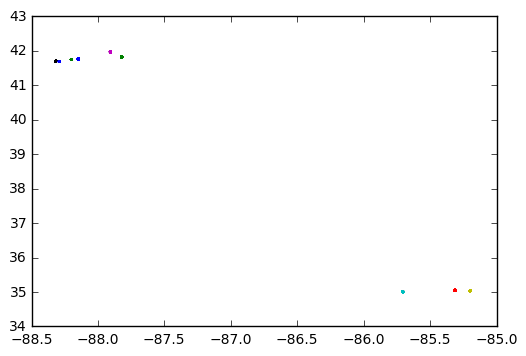

In [46]:
plt.scatter(dArray[l!=-1][:,1],dArray[l!=-1][:,0],color=colors[l[l!=-1]], s=1)

In [48]:
gmap = gmplot.GoogleMapPlotter(41.84,-87.75,12)
for c in np.unique(l[l!=-1]):
    m = [np.mean(dArray[l==c][:,0]), np.mean(dArray[l==c][:,1])]
    # Size based on physical space covered by cluster
    s1 = (np.max(dArray[l==c][:,0])-np.min(dArray[l==c][:,0]))
    s2 = (np.max(dArray[l==c][:,1])-np.min(dArray[l==c][:,1]))
    print(s1*s2)
    
#     # Size based on time spent in cluster
#     s1 = sum(l==c)
#     s2=1000
#     print(math.sqrt(s1*s2))
    
    # colorscale based on weartime fraction
    col = sum((l==c) & (Data['Wear/Non-Wear']=='Wear'))/sum(l==c)
    
    gmap.scatter([m[0], m[0]],[m[1], m[1]],color='#%02x%02x%02x' % (int(col*255), 255-int(col*125), 0), size=math.sqrt(s1*s2/homeSize)*8, marker=False)
# Save as html
gmap.draw("CBR31_large.html")

2.15136999998e-06
5.49987999968e-07
2.90872399995e-06
1.636938e-06
2.23440000001e-06
2.80098e-06
7.16379999987e-07
2.529786e-06
9.79550999967e-07


In [107]:
col

0.06706586826347305

## Local Community Clustering

In [3]:
Data = pd.read_csv('Z:/C Brace/GPS Analysis/GPSWT/CBR31_CBrace.csv')

Lat = Data.LATITUDE
Lon = Data.LONGITUDE

Data.loc[Data['E/W']=="W","LONGITUDE"] = Data.loc[Data['E/W']=="W","LONGITUDE"]*-1

dArray = Data[["LATITUDE","LONGITUDE"]].values

In [6]:
dbscan = DBSCAN(metric='haversine', eps=1000/6371000, min_samples=int(180*len(dArray)/10000), algorithm='ball_tree')
t0 = time.clock()
clusters = dbscan.fit(np.radians(dArray))
t1 = time.clock()
print(t1-t0)

323.2384070918065


In [7]:
l=clusters.labels_
print(len(l))
np.unique(l)

183368


array([-1,  0,  1,  2])

In [13]:
dbscan = DBSCAN(metric='haversine', eps=25/6371000, min_samples=int(180*len(dArray)/100000), algorithm='ball_tree')

for i in np.unique(l[l!=-1]):
    clustData = dArray[l==i]
    clusters = dbscan.fit(np.radians(clustData))
    print(len(np.unique(clusters.labels_)))
    for li in np.unique(clusters.labels_):
        print(sum(clusters.labels_==li))

2
80
5008
2
784
157199
2
233
4723


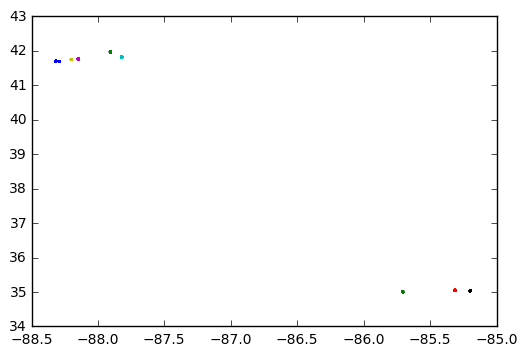

In [119]:
plt.scatter(dArray[l!=-1][:,1],dArray[l!=-1][:,0],color=colors[l[l!=-1]], s=1)

In [78]:
maxClust = -1
maxClustNum = 0
for i in range(0,len(np.unique(l))-1):
    print(i)
    if sum(l==i)>maxClustNum:
        maxClust = i
        maxClustNum = sum(l==i)
    
# HomeData = dArray[l==maxClust]
HomeData = dArray[l==0]
Wear = Data['Wear/Non-Wear'][l==maxClust] =='Wear'

0


In [90]:
dbscan = DBSCAN(metric='haversine', eps=100/6371000, min_samples=int(2000*len(HomeData)/100000), algorithm='ball_tree')
t0 = time.clock()
clusters = dbscan.fit(np.radians(HomeData))
t1 = time.clock()
print(t1-t0)

770.8210415907597


In [91]:
l=clusters.labels_
print(len(l))
np.unique(l)

247477


array([-1,  0])

In [92]:
colors=np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmyk'])

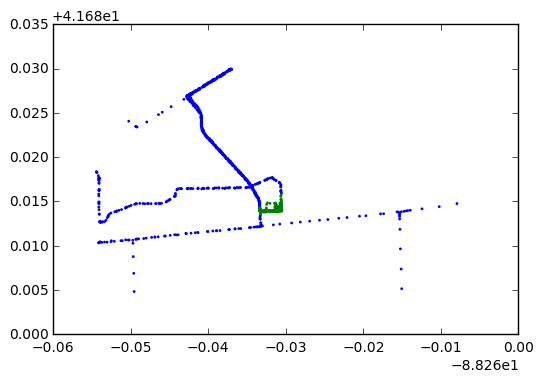

In [93]:
plt.scatter(HomeData[l!=-2][:,1],HomeData[l!=-2][:,0],color=colors[l[l!=-2]+1], s=1)

In [88]:
gmap = gmplot.GoogleMapPlotter(41.84,-87.75,12)

for c in np.unique(l[l!=-1]):
    d = np.vstack({tuple(row) for row in np.around(HomeData[l==c],decimals=5)})
    col = sum((l==c) & (Wear))/sum(l==c)
    
    gmap.scatter(d[:,0],d[:,1],color='#%02x%02x%02x' % (int(col*255), 255-int(col*125), 0), size=5, marker=False)
# Save as html
gmap.draw("SCO31.html")

In [73]:
d

array([[ 41.69438, -88.29136],
       [ 41.69415, -88.29099],
       [ 41.69386, -88.29179],
       ..., 
       [ 41.69407, -88.29129],
       [ 41.69407, -88.29111],
       [ 41.69389, -88.29309]])

In [62]:
np.vstack({tuple(row) for row in d}).shape

(29068, 2)

In [68]:
np.vstack({tuple(row) for row in np.around(HomeData[l==c],decimals=5)}).shape

(1352, 2)

In [86]:
for i, row in enumerate(d):
    print(row)

[ 41.69411 -88.29137]
[ 41.69429 -88.29119]
[ 41.69444 -88.29124]
[ 41.69396 -88.29114]
[ 41.69404 -88.29131]
[ 41.69425 -88.29111]
[ 41.69438 -88.29112]
[ 41.69395 -88.29114]
[ 41.69428 -88.29112]
[ 41.6941 -88.2913]
[ 41.69414 -88.29116]
[ 41.69422 -88.29138]
[ 41.69404 -88.2912 ]
[ 41.69392 -88.2928 ]
[ 41.69419 -88.29127]
[ 41.69415 -88.29116]
[ 41.6941  -88.29118]
[ 41.69437 -88.29109]
[ 41.69406 -88.29107]
[ 41.69416 -88.29125]
[ 41.69427 -88.29114]
[ 41.69409 -88.29119]
[ 41.69391 -88.29209]
[ 41.69436 -88.29128]
[ 41.69424 -88.29113]
[ 41.69411 -88.29127]
[ 41.69407 -88.29134]
[ 41.69388 -88.29149]
[ 41.69393 -88.29109]
[ 41.69412 -88.29112]
[ 41.694   -88.29113]
[ 41.69424 -88.29123]
[ 41.69438 -88.29117]
[ 41.69397 -88.29114]
[ 41.69417 -88.29122]
[ 41.69408 -88.29059]
[ 41.69408 -88.29131]
[ 41.69406 -88.2912 ]
[ 41.69414 -88.29101]
[ 41.69396 -88.29119]
[ 41.69423 -88.29128]
[ 41.69434 -88.29128]
[ 41.69416 -88.2911 ]
[ 41.69465 -88.29129]
[ 41.6942 -88.2912]
[ 41.69411 -88

In [87]:
d

array([[ 41.69411, -88.29137],
       [ 41.69429, -88.29119],
       [ 41.69444, -88.29124],
       ..., 
       [ 41.69401, -88.29115],
       [ 41.69418, -88.29124],
       [ 41.69409, -88.29115]])

In [89]:
col

0.32536554509403204